# IMD3004 - Aprendizado Profundo

### Professor: Dr. Silvan Ferreira da Silva Junior

### Aluno: João Antonio Costa Paiva Chagas

## Importações

In [ ]:
import torch
import torchvision
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

## Dados

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Funções auxiliares

In [ ]:
def run_experiment(model, train_loader, test_loader, learning_rate=0.001, num_epochs=5):
    """
    Executa um experimento de treinamento e validação completo para um dado modelo.
    """
    # Dispositivo (GPU se disponível, senão CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"--- Iniciando Experimento: {model.__class__.__name__} em {device} ---")

    # Move o modelo para o dispositivo
    model.to(device)

    # Define a função de custo e o otimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Dicionário para armazenar o histórico de métricas
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    # Loop de treinamento
    for epoch in range(num_epochs):
        # --- Fase de Treinamento ---
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        train_pbar = tqdm(train_loader, desc=f'Época {epoch+1}/{num_epochs} [Treino]')
        for images, labels in train_pbar:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            train_pbar.set_postfix({'Perda': f'{loss.item():.4f}'})

        # --- Fase de Validação ---
        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0

        val_pbar = tqdm(test_loader, desc=f'Época {epoch+1}/{num_epochs} [Validação]')
        with torch.no_grad():
            for images, labels in val_pbar:
                images = images.reshape(-1, 28*28).to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                val_pbar.set_postfix({'Perda': f'{loss.item():.4f}'})

        # Armazena as métricas da época
        history['train_loss'].append(running_loss / len(train_loader))
        history['train_acc'].append(100 * correct_train / total_train)
        history['val_loss'].append(running_val_loss / len(test_loader))
        history['val_acc'].append(100 * correct_val / total_val)

        print(f"Fim da Época {epoch+1} | "
              f"Treino: Perda={history['train_loss'][-1]:.4f}, Acc={history['train_acc'][-1]:.2f}% | "
              f"Validação: Perda={history['val_loss'][-1]:.4f}, Acc={history['val_acc'][-1]:.2f}%")

    print("--- Experimento Concluído ---\n")
    return history

In [ ]:
def plot_comparison(history1, label1, history2, label2):
    """
    Plota as curvas de perda e acurácia de dois experimentos para comparação.
    """
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot da Curva de Perda
    axs[0].plot(history1['train_loss'], 'c--', label=f'Treino ({label1})')
    axs[0].plot(history1['val_loss'], 'c-', label=f'Validação ({label1})')
    axs[0].plot(history2['train_loss'], 'm--', label=f'Treino ({label2})')
    axs[0].plot(history2['val_loss'], 'm-', label=f'Validação ({label2})')
    axs[0].set_title("Curvas de Perda")
    axs[0].set_xlabel("Época")
    axs[0].set_ylabel("Perda (Cross-Entropy)")
    axs[0].legend()
    axs[0].grid(True)

    # Plot da Curva de Acurácia
    axs[1].plot(history1['train_acc'], 'c--', label=f'Treino ({label1})')
    axs[1].plot(history1['val_acc'], 'c-', label=f'Validação ({label1})')
    axs[1].plot(history2['train_acc'], 'm--', label=f'Treino ({label2})')
    axs[1].plot(history2['val_acc'], 'm-', label=f'Validação ({label2})')
    axs[1].set_title("Curvas de Acurácia")
    axs[1].set_xlabel("Época")
    axs[1].set_ylabel("Acurácia (%)")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

## Treinamento original

In [ ]:
class NeuralNetwork1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork1, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out

In [ ]:
input_size_original = 784
hidden_size_original = 500
num_classes_original = 10
learning_rate_original = 0.001
num_epochs = 5

model1 = NeuralNetwork1(input_size_original, hidden_size_original, num_classes_original)
history1 = run_experiment(model1, train_loader, test_loader, learning_rate_original, num_epochs)

--- Iniciando Experimento: NeuralNetwork1 em cpu ---


Época 1/5 [Validação]: 100%|██████████| 79/79 [00:03<00:00, 24.58it/s, Perda=0.0216]


Fim da Época 1 | Treino: Perda=0.2337, Acc=93.21% | Validação: Perda=0.1113, Acc=96.80%


Época 2/5 [Validação]: 100%|██████████| 79/79 [00:02<00:00, 29.23it/s, Perda=0.0181]


Fim da Época 2 | Treino: Perda=0.0896, Acc=97.33% | Validação: Perda=0.0780, Acc=97.52%


Época 3/5 [Validação]: 100%|██████████| 79/79 [00:02<00:00, 30.41it/s, Perda=0.0022]


Fim da Época 3 | Treino: Perda=0.0587, Acc=98.16% | Validação: Perda=0.0766, Acc=97.60%


Época 4/5 [Validação]: 100%|██████████| 79/79 [00:04<00:00, 18.91it/s, Perda=0.0020]


Fim da Época 4 | Treino: Perda=0.0417, Acc=98.67% | Validação: Perda=0.0725, Acc=97.74%


Época 5/5 [Validação]: 100%|██████████| 79/79 [00:02<00:00, 29.30it/s, Perda=0.0006]

Fim da Época 5 | Treino: Perda=0.0320, Acc=98.97% | Validação: Perda=0.0762, Acc=97.66%
--- Experimento Concluído ---



## Exercícios

### Exercício 1: Praticando com o `autograd`

Calcule os gradientes da função $L = 2a^3 + 3b^2$ em relação a `a` e `b`.

#### 1.  Defina dois tensores, `a` e `b`, com os valores `a=2.0` e `b=5.0`. Lembre-se de definir `requires_grad=True`.

In [ ]:
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(5.0, requires_grad=True)

#### 2.  Escreva a operação em PyTorch para calcular `L`.

In [ ]:
L = 2*a**3 + 3*b**2

#### 3.  Use `.backward()` para calcular os gradientes.

In [ ]:
L.backward()

#### 4.  Imprima `a.grad` e `b.grad`.

In [ ]:
print(f"Gradiente dL/da: {a.grad}")
print(f"Gradiente dL/db: {b.grad}")

Gradiente dL/da: 24.0
Gradiente dL/db: 30.0


#### 5.  **Verificação:** Calcule as derivadas parciais $\frac{\partial L}{\partial a}$ e $\frac{\partial L}{\partial b}$ manualmente e confirme se os resultados correspondem aos do PyTorch.

In [ ]:
print(f"  - Cálculo manual: 2 * 3 * a**2 + 0 (constante em relação à a) = {2 * 3 * a**2 + 0}\n")
print(f"  - Cálculo manual: 0 (constante em relação à b) + 3 * 2 * b**2  = {0 + 3 * 2 * b}")

  - Cálculo manual: 2 * 3 * a**2 + 0 (constante em relação à a) = 24.0

  - Cálculo manual: 0 (constante em relação à b) + 3 * 2 * b**2  = 30.0


### Exercício 2: Aprofundando a Arquitetura da Rede

Modifique a classe `NeuralNetwork` para que ela tenha **duas camadas ocultas** em vez de uma. A nova arquitetura deve ser:
`Entrada (784) -> Camada Linear (256 neurônios) -> ReLU -> Camada Linear (128 neurônios) -> ReLU -> Saída (10 neurônios)`. Em seguida, treine o novo modelo e compare com as curvas de treinamento do modelo original.

#### Modificação na rede

In [ ]:
class NeuralNetwork2(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
        super(NeuralNetwork2, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size_1)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size_2, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.layer3(out)
        return out

#### Instanciando e treinando

In [ ]:
model2 = NeuralNetwork2(input_size=784, hidden_size_1=256, hidden_size_2=128, num_classes=10)
history2 = run_experiment(model2, train_loader, test_loader, learning_rate_original, num_epochs)

--- Iniciando Experimento: NeuralNetwork2 em cpu ---


Época 1/5 [Validação]: 100%|██████████| 79/79 [00:03<00:00, 22.80it/s, Perda=0.0095]


Fim da Época 1 | Treino: Perda=0.2649, Acc=92.22% | Validação: Perda=0.1294, Acc=96.02%


Época 2/5 [Validação]: 100%|██████████| 79/79 [00:02<00:00, 30.46it/s, Perda=0.0017]


Fim da Época 2 | Treino: Perda=0.1029, Acc=96.84% | Validação: Perda=0.0912, Acc=97.13%


Época 3/5 [Validação]: 100%|██████████| 79/79 [00:02<00:00, 27.09it/s, Perda=0.0010]


Fim da Época 3 | Treino: Perda=0.0684, Acc=97.90% | Validação: Perda=0.0748, Acc=97.72%


Época 4/5 [Validação]: 100%|██████████| 79/79 [00:02<00:00, 29.86it/s, Perda=0.0024]


Fim da Época 4 | Treino: Perda=0.0525, Acc=98.32% | Validação: Perda=0.0752, Acc=97.74%


Época 5/5 [Validação]: 100%|██████████| 79/79 [00:03<00:00, 23.69it/s, Perda=0.0018]

Fim da Época 5 | Treino: Perda=0.0390, Acc=98.70% | Validação: Perda=0.0674, Acc=97.94%
--- Experimento Concluído ---



#### Comparação das curvas de treinamento

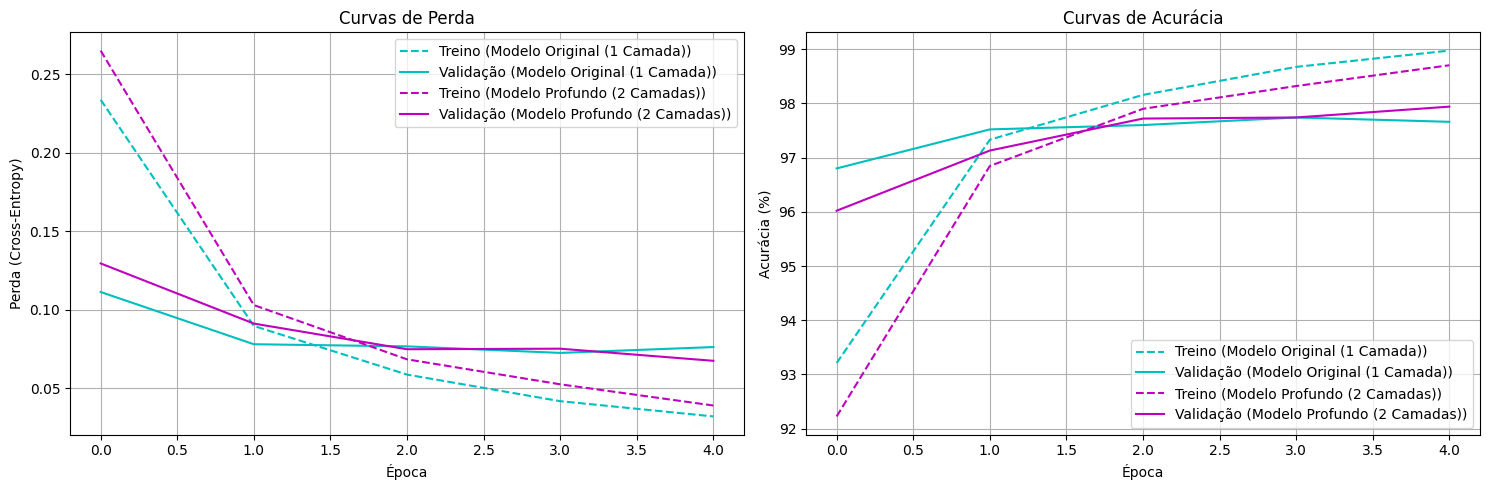

In [ ]:
plot_comparison(history1, "Modelo Original (1 Camada)", history2, "Modelo Profundo (2 Camadas)")

O Modelo Profundo (curvas roxas) apresenta um desempenho ligeiramente superior. Ele atinge uma perda final menor e uma acurácia de validação maior (próximo de 98%) em comparação com o modelo original (curvas azuis).

### Exercício 3: Otimizadores e Taxa de Aprendizado

Altere a taxa de aprendizado no loop de treinamento. Utilize valores maiores (como `lr=1.0`) e menores (como `lr=0.0001`) do que o original. Como as curvas de treinamento se comportaram em cada ocasião?

#### Com taxa de aprendizado maior

--- Iniciando Experimento: NeuralNetwork1 em cpu ---


Época 1/5 [Validação]: 100%|██████████| 79/79 [00:03<00:00, 22.64it/s, Perda=2.3640]


Fim da Época 1 | Treino: Perda=353.3826, Acc=19.72% | Validação: Perda=2.8002, Acc=18.69%


Época 2/5 [Validação]: 100%|██████████| 79/79 [00:02<00:00, 29.22it/s, Perda=2.3712]


Fim da Época 2 | Treino: Perda=2.4907, Acc=17.04% | Validação: Perda=2.6042, Acc=18.21%


Época 3/5 [Validação]: 100%|██████████| 79/79 [00:03<00:00, 22.81it/s, Perda=2.3430]


Fim da Época 3 | Treino: Perda=3.2198, Acc=14.75% | Validação: Perda=2.7222, Acc=11.00%


Época 4/5 [Validação]: 100%|██████████| 79/79 [00:03<00:00, 23.92it/s, Perda=2.4398]


Fim da Época 4 | Treino: Perda=2.3209, Acc=13.93% | Validação: Perda=2.7850, Acc=11.10%


Época 5/5 [Validação]: 100%|██████████| 79/79 [00:02<00:00, 30.08it/s, Perda=2.3814]


Fim da Época 5 | Treino: Perda=2.6739, Acc=11.13% | Validação: Perda=2.7545, Acc=11.02%
--- Experimento Concluído ---



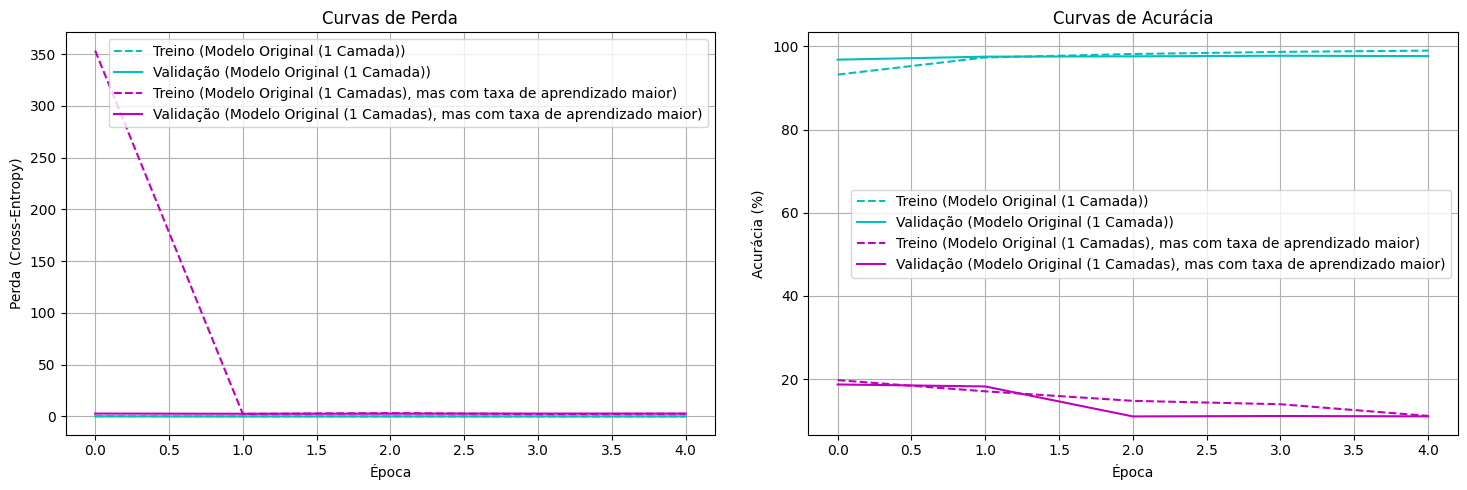

In [ ]:
learning_rate_maior = 1.0
model1 = NeuralNetwork1(input_size_original, hidden_size_original, num_classes_original)
history3 = run_experiment(model1, train_loader, test_loader, learning_rate_maior, num_epochs)
plot_comparison(history1, "Modelo Original (1 Camada)", history3, "Modelo Original (1 Camadas), mas com taxa de aprendizado maior")

A taxa de aprendizado maior (curvas roxas) causou uma instabilidade extrema. A perda explodiu para valores muito altos e a acurácia ficou estagnada em torno de 10-20%, o que é bem pior que um palpite aleatório.

#### Com taxa de aprendizado menor

--- Iniciando Experimento: NeuralNetwork1 em cpu ---


Época 1/5 [Validação]: 100%|██████████| 79/79 [00:03<00:00, 24.54it/s, Perda=0.1294]


Fim da Época 1 | Treino: Perda=0.5473, Acc=86.31% | Validação: Perda=0.2751, Acc=92.15%


Época 2/5 [Validação]: 100%|██████████| 79/79 [00:02<00:00, 26.94it/s, Perda=0.0802]


Fim da Época 2 | Treino: Perda=0.2516, Acc=92.95% | Validação: Perda=0.2100, Acc=93.97%


Época 3/5 [Validação]: 100%|██████████| 79/79 [00:02<00:00, 30.01it/s, Perda=0.0401]


Fim da Época 3 | Treino: Perda=0.1958, Acc=94.50% | Validação: Perda=0.1707, Acc=94.93%


Época 4/5 [Validação]: 100%|██████████| 79/79 [00:02<00:00, 29.77it/s, Perda=0.0385]


Fim da Época 4 | Treino: Perda=0.1603, Acc=95.49% | Validação: Perda=0.1465, Acc=95.63%


Época 5/5 [Validação]: 100%|██████████| 79/79 [00:02<00:00, 29.34it/s, Perda=0.0219]


Fim da Época 5 | Treino: Perda=0.1351, Acc=96.23% | Validação: Perda=0.1264, Acc=96.21%
--- Experimento Concluído ---



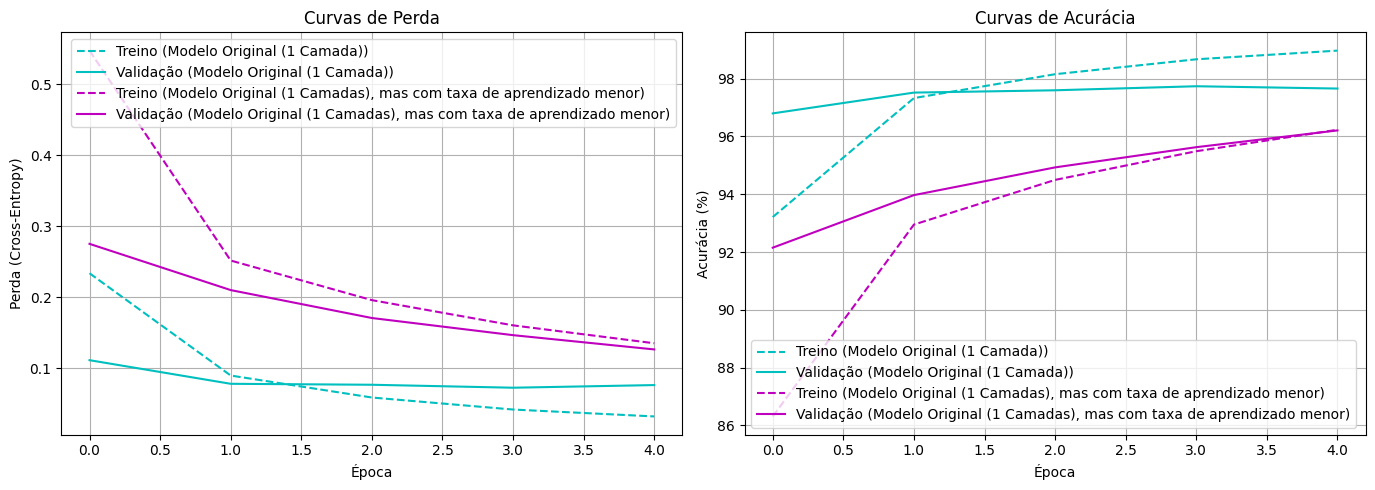

In [ ]:
learning_rate_menor = 0.0001
model1 = NeuralNetwork1(input_size_original, hidden_size_original, num_classes_original)
history4 = run_experiment(model1, train_loader, test_loader, learning_rate_menor, num_epochs)
plot_comparison(history1, "Modelo Original (1 Camada)", history4, "Modelo Original (1 Camadas), mas com taxa de aprendizado menor")

A taxa de aprendizado menor (curvas roxas) resultou em um aprendizado mais lento do que o modelo que utiliza a taxa de aprendizado original (curvas azuis). Apesar de que a perda esteja diminuindo e a acurácia aumentando, ao final das 5 épocas, o modelo ainda não alcançou o mesmo nível de performance do modelo com a taxa de aprendizado original (curvas azuis).

### Exercício 4: Criando um Dataset para Regressão

Crie uma classe de `Dataset` customizada para um problema de regressão simples. O dataset deve gerar dados sintéticos onde `y` é uma função linear de `x` com um pouco de ruído.

Crie uma classe `RegressionDataset` que herde de `torch.utils.data.Dataset`. No `__init__`, crie um tensor `X` com 1000 pontos aleatórios entre -10 e 10 e crie um tensor `y` correspondente usando a fórmula $y = 5x - 3 + \text{ruído}$ (use `torch.randn` para o ruído). Implemente os métodos `__len__` e `__getitem__` e use um `DataLoader` para extrair o primeiro lote (batch). Imprima o formato dos tensores de features e labels do lote para confirmar que seu pipeline de dados está funcionando corretamente.

#### Dataset customizado

In [ ]:
class RegressionDataset(Dataset):
    def __init__(self, num_samples=1000):
        self.X = torch.linspace(-10, 10, num_samples).unsqueeze(1)
        noise = torch.randn(num_samples, 1) * 2
        self.y = 5 * self.X - 3 + noise

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

#### Instanciando o Dataset e criando o DataLoader

In [ ]:
dataset = RegressionDataset()
dataloader = DataLoader(dataset, batch_size=50, shuffle=True)

#### Extraindo e imprimindo

In [ ]:
features_lote, labels_lote = next(iter(dataloader))
print(f"Formato do lote de features (X): {features_lote.shape}")
print(f"Formato do lote de labels (y): {labels_lote.shape}")

print("\nExemplo de alguns dados do primeiro lote:")
for i in range(25):
    print(f"  Feature: {features_lote[i].item():.2f}, Label: {labels_lote[i].item():.2f}")

Formato do lote de features (X): torch.Size([50, 1])
Formato do lote de labels (y): torch.Size([50, 1])

Exemplo de alguns dados do primeiro lote:
  Feature: 2.85, Label: 12.30
  Feature: 0.37, Label: -2.58
  Feature: 0.93, Label: -1.60
  Feature: -8.64, Label: -47.29
  Feature: -5.86, Label: -32.61
  Feature: 9.52, Label: 41.14
  Feature: -1.03, Label: -8.21
  Feature: -2.55, Label: -16.39
  Feature: -6.14, Label: -35.47
  Feature: -0.79, Label: -11.42
  Feature: -6.76, Label: -36.48
  Feature: 5.74, Label: 24.75
  Feature: -2.01, Label: -12.55
  Feature: 4.39, Label: 16.16
  Feature: 0.57, Label: 3.07
  Feature: 2.39, Label: 10.70
  Feature: -0.91, Label: -6.78
  Feature: 6.80, Label: 28.90
  Feature: 0.23, Label: -1.57
  Feature: -3.17, Label: -18.84
  Feature: 1.85, Label: 4.53
  Feature: 4.31, Label: 21.41
  Feature: 8.40, Label: 42.40
  Feature: 4.71, Label: 19.75
  Feature: -1.55, Label: -8.59
